<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocessing

Collection:

In [6]:
import pandas as pd

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


# print("\nInitial samples:")
# print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

Label Distribution:

In [7]:
print("\nLabel distribution in each dataframe:")

total_benign = 0
total_malicious = 0

label_counts = cicids2017_df['Attack Type'].value_counts(dropna=False)
print(label_counts.to_string())

for label, count in label_counts.items():
  if str(label).strip() == 'Normal Traffic':
    total_benign += count
  else:
    total_malicious += count

print(f"\nTotal benign traffic: {total_benign}")
print(f"Total malicious traffic: {total_malicious}")




Label distribution in each dataframe:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948

Total benign traffic: 2095057
Total malicious traffic: 425694


Encoding:

In [8]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# # Initialise LabelEncoder
# le = LabelEncoder()

# # Encode the 'Attack Type' column values
# cicids2017_df['Attack Type'] = le.fit_transform(cicids2017_df['Attack Type'])

# # Print unique values in the 'Attack Type' column after encoding
# print("\nUnique values in 'Attack Type' after encoding:")
# print(cicids2017_df['Attack Type'].unique())

# # Create a dictionary of attack type to encoding
# attack_type_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# print("\nAttack Type to Encoding Mapping:")
# print(attack_type_mapping)

cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].apply(lambda x: 0 if x == 'Normal Traffic' else 1)

Train/Test Split

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Separate Benign and Malicious Traffic ---

# Separate benign and malicious samples
# benign_df = cicids2017_df[cicids2017_df['Attack Type'] == 'Normal Traffic']
# malicious_df = cicids2017_df[cicids2017_df['Attack Type'] != 'Normal Traffic']
benign_df = cicids2017_df[cicids2017_df['Attack Type'] == 0]
malicious_df = cicids2017_df[cicids2017_df['Attack Type'] == 1]

# Separate features (X) and labels (y) for benign data
X_benign = benign_df.drop('Attack Type', axis=1)
y_benign = benign_df['Attack Type']

# Separate features (X) and labels (y) for malicious data
X_malicious = malicious_df.drop('Attack Type', axis=1)
y_malicious = malicious_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X_benign, y_benign, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Create test set
X_test = pd.concat([X_test, X_malicious], ignore_index=True)
y_test = pd.concat([y_test, y_malicious], ignore_index=True)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

Normalise the data:

In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import numpy as np

# --- Normalize ---
# Initialize the scaler
scaler = RobustScaler()

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")

# Check for NaNs or Infs in the scaled data
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())


Shape of X_train after scaling: (1005627, 52)
Shape of X_val after scaling: (251407, 52)
Shape of X_test after scaling: (1263717, 52)
NaN in X_train: False
Inf in X_train: False


#Autoencoder model
An autoencoder model consists of two parts:
- **Encoder**: Responsible for compressing the input data into a lower-dimensional representation of the input data that captures the most important information.
- **Decoder**: Responsible for reconstructing the input data from the latent space representation. The decoder takes the latent space representation as input and produces a reconstructed version of the input data as output. The reconstructed data should be as similar as possible to the original input data.

- Advantages of autoencoders: Can be used to detect anomalies, unsupervised learning models (they do not require labeled data in training), easy to train and implement.
- Disadvantages of autoencoders: computationally expensive to train (especially for large datasets.), they are sensitive to the choice of hyperparameters, difficult to interpret.

Below is a simple autoencoder model with three layers in the encoder and three layers in the decoder. https://levelup.gitconnected.com/build-deep-autoencoders-model-for-anomaly-detection-in-python-a-complete-guide-a7d0ec0e688
https://medium.com/@ndhilani.simbine/how-i-built-a-real-time-anomaly-detection-system-for-enterprise-networks-using-python-and-machine-0078d8a26e84
https://medium.com/@walid.daboubi/malware-detection-using-deep-autoencoder-neural-network-wannacry-as-a-test-9d0125c925b2

In [11]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
import numpy as np # Import numpy

# Determine the input dimension from the scaled training data
input_dim = X_train.shape[1]
print(f"Autoencoder input dimension: {input_dim}")

autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation='relu'),                             # Encoder layer
    Dense(32, activation='relu'),                             # Encoder layer
    Dense(16, activation='relu'),                             # Encoder bottleneck
    Dense(32, activation='relu'),                             # Decoder layer
    Dense(64, activation='relu'),                             # Decoder layer
    Dense(input_dim, activation='linear')                    # Output layer (same size as input)
])

autoencoder.compile(optimizer='adam', loss='mse')

Autoencoder input dimension: 52


# Train and test the model

Epoch 1/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 154477510656.0000 - val_loss: 5213740544.0000
Epoch 2/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - loss: 4107861248.0000 - val_loss: 388087104.0000
Epoch 3/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 2917550848.0000 - val_loss: 865819328.0000
Epoch 4/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 2240932352.0000 - val_loss: 609678080.0000
Epoch 5/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 2000737280.0000 - val_loss: 1141387136.0000
Epoch 6/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 2026382208.0000 - val_loss: 538181696.0000
Epoch 7/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 1986309760.0000 - val_loss: 425550656.0000
Epoch 8/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 1831027200.0000 - val_loss: 658857536.0000
Epoch 9/10
15713/15713 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 1731281408.0000 - val_loss: 2006570752.0000
Epoch 10/10
15713/15713

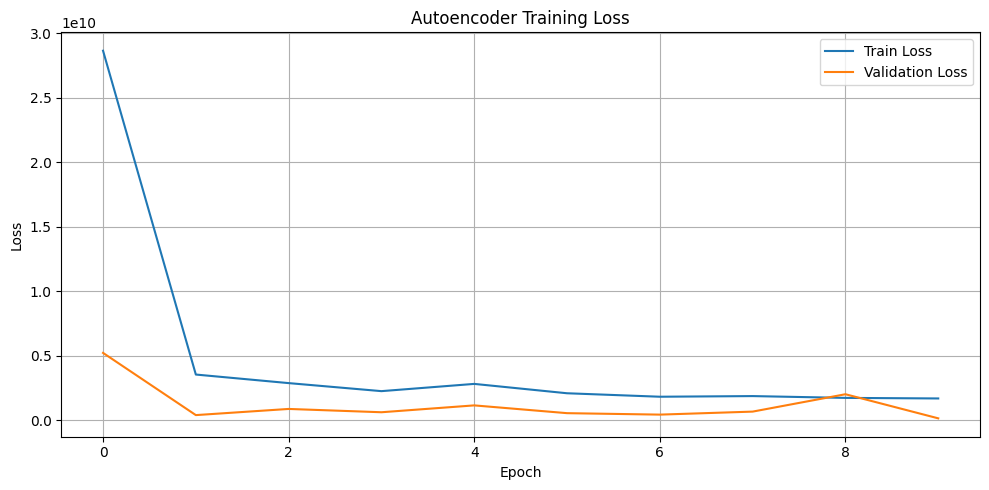

In [12]:
import matplotlib.pyplot as plt
import timeit

# Start timing
start_time = timeit.default_timer()

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,  # Autoencoders use X_train as both input and target
    epochs=10,
    batch_size=64,
    validation_data=(X_val, X_val),  # Add validation data set
    verbose=1 # Show a progress bar with real-time updates for each epoch
)


# End timing
end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#Test the model

In [13]:
# Evaluate the model on the test data
loss = autoencoder.evaluate(X_test, X_test) # Evaluate() already returns mean squared error

# Calculate the anomaly score (by calculating the reconstruction errors for the test data)
reconstructions = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.square(reconstructions - X_test), axis=1) # Compute the average squared error per sample (difference between the original input and the reconstruction output in the autoencoder)


# Threshold the reconstruction errors to identify anomalies
# threshold = np.percentile(reconstruction_errors, 95)
# anomalies = np.where(reconstruction_errors > threshold)[0]
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors) # Threshold = μ + 2σ (the average reconstruction error across all test samples + 2 standard deviations from the mean)

anomalies = np.where(reconstruction_errors > threshold)[0] # Which samples (by index) are anomalous. If a samples reconstruction error is bigger than the threshold then flag it as malicious
y_pred = (reconstruction_errors > threshold).astype(int) # Label prediction for each sample

# Print the number of anomalies detected
print(f'Number of anomalies detected: {len(y_pred)} out of {np.sum(y_test == 1)} malicious samples')

39492/39492 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - loss: 1467766272.0000
Test loss: 4367178752.0
39492/39492 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step
Number of anomalies detected: 1263717 out of 425694 malicious samples


# Evaluate model predictions against ground truth

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy scores
print("\nAccuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))
print(f"Confusion Matrix Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

Confusion Matrix:
[[838017      6]
 [425694      0]]

True Negatives (Benign correctly classified): 838017
False Positives (Benign misclassified as malware): 6
False Negatives (Malware missed): 425694
True Positives (Malware correctly identified): 0
Accuracy:
sklearn Accuracy: 0.6631366041605834
 Confusion Matrix Accuracy: 0.6631366041605834

Classification Report:
              precision    recall  f1-score   support

      Benign       0.66      1.00      0.80    838023
   Malicious       0.00      0.00      0.00    425694

    accuracy                           0.66   1263717
   macro avg       0.33      0.50      0.40   1263717
weighted avg       0.44      0.66      0.53   1263717



#Reconstruction Error Plot



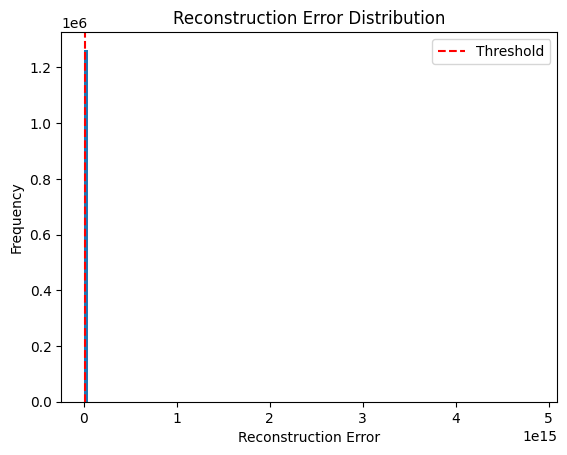

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# --- Visualize reconstruction error ---
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors), color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Input Vs Reconstruction for X_test[0]

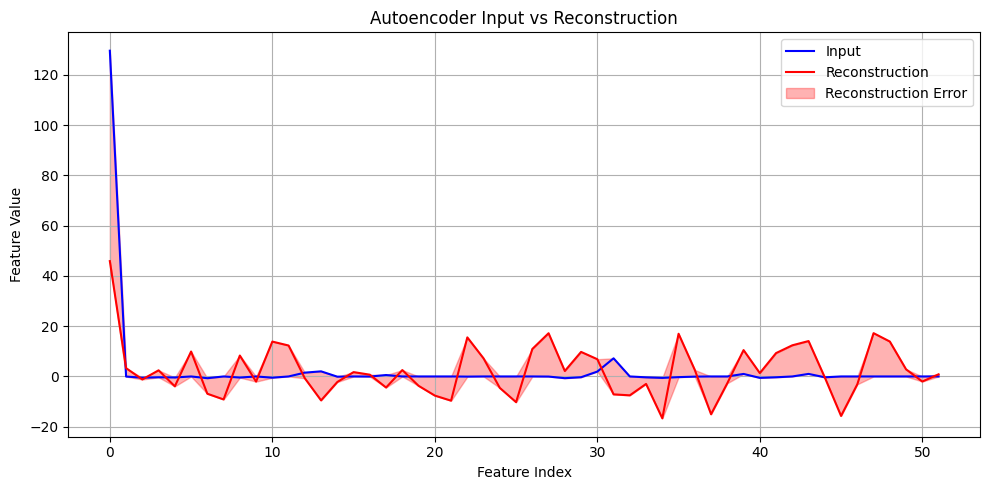

In [16]:
import matplotlib.pyplot as plt
import numpy as np

sample_idx = 0  # change this to try different samples

# Get the input sample and reconstruction
input_sample = X_test[sample_idx]
reconstructed_sample = autoencoder.predict(X_test[sample_idx][np.newaxis, ...], verbose=0)[0]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(input_sample, label='Input', color='blue')
plt.plot(reconstructed_sample, label='Reconstruction', color='red')

# Error band
plt.fill_between(np.arange(len(input_sample)),
                 np.minimum(input_sample, reconstructed_sample),
                 np.maximum(input_sample, reconstructed_sample),
                 color='red', alpha=0.3, label='Reconstruction Error')

plt.legend()
plt.title("Autoencoder Input vs Reconstruction")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.grid(True)
plt.tight_layout()
plt.show()



In [17]:
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(input_dim,)),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dense(num_classes, activation='softmax')  # Output layer for multiclass classification
# ])

# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' for one-hot labels
#     metrics=['accuracy']
# )

# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)